Most code from https://www.kaggle.com/code/farzadnekouei/real-time-traffic-density-estimation-with-yolov8

Dataset from https://www.kaggle.com/datasets/farzadnekouei/top-view-vehicle-detection-image-dataset?resource=download

In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'top-view-vehicle-detection-image-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4107330%2F7166601%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240223%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240223T130121Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D72aa707f3c22125169a5cc701abd92b95ce1d3c1ed4a97e3ff852f1429da7dd933e61e2f987b3da76d41f05660f5df3346f60825713f2df160f2286310e7202f9cbb796ab528f9862397b133e6e77287490b9784db050ffa3a4063ef2ba427caed5ee5614e80951191f9468a5a18f6a438520ecac3986f875d6617ae3cf16a1d2d85407a862236a57d9ee95124846974689a23f5ded7a73d2400be50021c75b0c3d8a279cea0d851f18d5112d25f4649d158f6d7adf1c8c147100f81e263a684d011cf54b1e6cb56689ec92ea22965cd770323f6c26ae168371e55d97d81c180817cf961328163810e7b478cc196f8ec8770ff5ba9da78081a69502d3da7ee45'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


OSError: [Errno 30] Read-only file system: '/kaggle'

In [2]:
# Install Ultralytics library
!pip install ultralytics

In [2]:
# Disable warnings in the notebook to maintain clean output cells
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import yaml
from PIL import Image
from ultralytics import YOLO
from IPython.display import Video

In [3]:
# Configure the visual appearance of Seaborn plots
sns.set(rc={'axes.facecolor': '#eae8fa'}, style='darkgrid')

In [4]:
# Load a pretrained YOLOv8n model from Ultralytics
model = YOLO('yolov8n.pt')


image 1/1 /Users/joaobarbosa/traffic-ai/valid/images/14_mp4-15_jpg.rf.9640ab027504af3733b76827756764eb.jpg: 640x640 1 person, 5 cars, 1 truck, 604.7ms
Speed: 48.3ms preprocess, 604.7ms inference, 56.9ms postprocess per image at shape (1, 3, 640, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine g

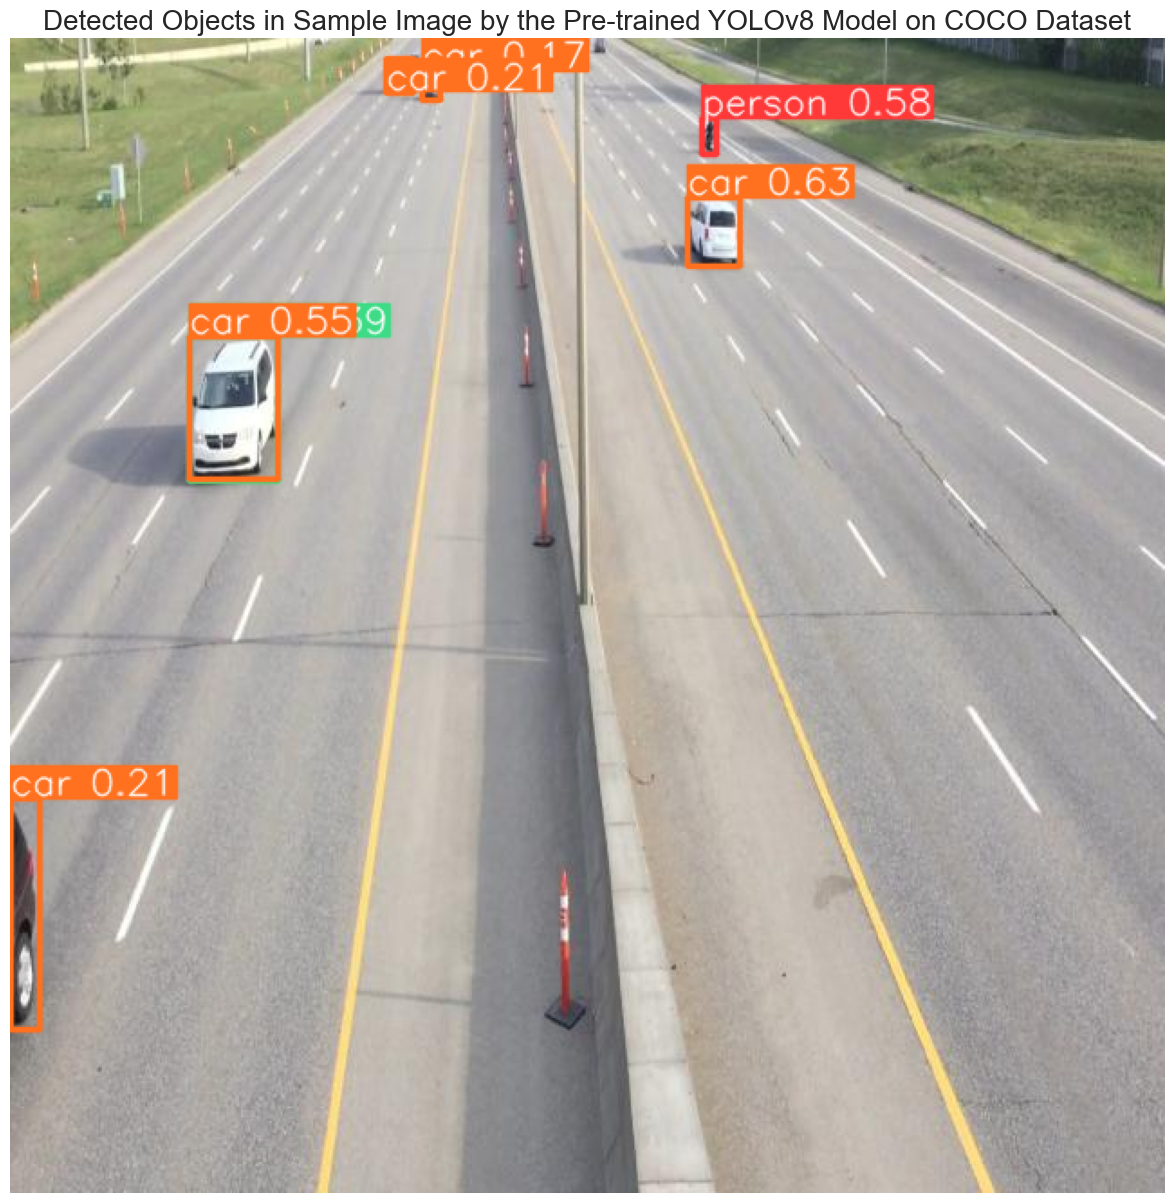

In [13]:
# Path to the image file
image_path = 'valid/images/14_mp4-15_jpg.rf.9640ab027504af3733b76827756764eb.jpg'

results = model([])

# Perform inference on the provided image(s)
results = model.predict(source=image_path,
                        imgsz=640,  # Resize image to 640x640 (the size pf images the model was trained on)
                        conf=0.1)   # Confidence threshold: 50% (only detections above 50% confidence will be considered)

print(results)
# Annotate and convert image to numpy array
sample_image = results[0].plot(line_width=2)

# Convert the color of the image from BGR to RGB for correct color representation in matplotlib
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

# Display annotated image
plt.figure(figsize=(20,15))
plt.imshow(sample_image)
plt.title('Detected Objects in Sample Image by the Pre-trained YOLOv8 Model on COCO Dataset', fontsize=20)
plt.axis('off')
plt.show()

In [7]:
# Define the dataset_path
dataset_path = '/kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset'

# Set the path to the YAML file
yaml_file_path = os.path.join(dataset_path, 'data.yaml')

# Load and print the contents of the YAML file
with open(yaml_file_path, 'r') as file:
    yaml_content = yaml.load(file, Loader=yaml.FullLoader)

names:
- Vehicle
nc: 1
roboflow:
  license: CC BY 4.0
  project: vehicle_detection_yolov8
  url: https://universe.roboflow.com/farzad/vehicle_detection_yolov8/dataset/3
  version: 3
  workspace: farzad
train: ../train/images
val: ../valid/images



In [8]:
# Set paths for training and validation image sets
train_images_path = os.path.join(dataset_path, 'train', 'images')
valid_images_path = os.path.join(dataset_path, 'valid', 'images')

# Initialize counters for the number of images
num_train_images = 0
num_valid_images = 0

# Initialize sets to hold the unique sizes of images
train_image_sizes = set()
valid_image_sizes = set()

# Check train images sizes and count
for filename in os.listdir(train_images_path):
    if filename.endswith('.jpg'):
        num_train_images += 1
        image_path = os.path.join(train_images_path, filename)
        with Image.open(image_path) as img:
            train_image_sizes.add(img.size)

# Check validation images sizes and count
for filename in os.listdir(valid_images_path):
    if filename.endswith('.jpg'):
        num_valid_images += 1
        image_path = os.path.join(valid_images_path, filename)
        with Image.open(image_path) as img:
            valid_image_sizes.add(img.size)

# Print the results
print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_valid_images}")

# Check if all images in training set have the same size
if len(train_image_sizes) == 1:
    print(f"All training images have the same size: {train_image_sizes.pop()}")
else:
    print("Training images have varying sizes.")

# Check if all images in validation set have the same size
if len(valid_image_sizes) == 1:
    print(f"All validation images have the same size: {valid_image_sizes.pop()}")
else:
    print("Validation images have varying sizes.")

Number of training images: 536
Number of validation images: 90
All training images have the same size: (640, 640)
All validation images have the same size: (640, 640)


In [9]:
# List all jpg images in the directory
image_files = [file for file in os.listdir(train_images_path) if file.endswith('.jpg')]

# Select 8 images at equal intervals
num_images = len(image_files)
selected_images = [image_files[i] for i in range(0, num_images, num_images // 8)]

# Create a 2x4 subplot
fig, axes = plt.subplots(2, 4, figsize=(20, 11))

# Display each of the selected images
for ax, img_file in zip(axes.ravel(), selected_images):
    img_path = os.path.join(train_images_path, img_file)
    image = Image.open(img_path)
    ax.imshow(image)
    ax.axis('off')

plt.suptitle('Sample Images from Training Dataset', fontsize=20)
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [10]:
# Train the model on our custom dataset
results = model.train(
    data=yaml_file_path,     # Path to the dataset configuration file
    epochs=20,              # Number of epochs to train for
    imgsz=640,               # Size of input images as integer
    device=0,                # Device to run on, i.e. cuda device=0
    patience=50,             # Epochs to wait for no observable improvement for early stopping of training
    batch=32,                # Number of images per batch
    optimizer='auto',        # Optimizer to use, choices=[SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto]
    lr0=0.0001,              # Initial learning rate
    lrf=0.1,                 # Final learning rate (lr0 * lrf)
    dropout=0.1,             # Use dropout regularization
    seed=0                   # Random seed for reproducibility
)

Ultralytics YOLOv8.1.18 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/data.yaml, epochs=20, time=None, patience=50, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.1, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_c

train: Scanning /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/labels... 536 images, 0 backgrounds, 0 corrupt: 100%|██████████| 536/536 [00:00<00:00, 1208.76it/s]

train: New cache created: /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid/labels... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<00:00, 464.84it/s]


val: New cache created: /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid/labels.cache
Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      5.66G      2.423      2.957      1.839        377        640: 100%|██████████| 17/17 [00:17<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]

                   all         90        937     0.0103      0.297     0.0238     0.0106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       4.8G      1.477       1.26      1.191        368        640: 100%|██████████| 17/17 [00:10<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all         90        937      0.833      0.287      0.396       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.65G      1.288      0.997      1.072        253        640: 100%|██████████| 17/17 [00:10<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         90        937      0.845      0.721       0.81      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.59G      1.207     0.8777       1.03        355        640: 100%|██████████| 17/17 [00:15<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

                   all         90        937      0.817      0.818      0.877      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.59G      1.191     0.8417      1.028        345        640: 100%|██████████| 17/17 [00:15<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

                   all         90        937      0.851       0.82       0.91      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      5.38G      1.147     0.8008      1.007        352        640: 100%|██████████| 17/17 [00:11<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         90        937      0.872      0.872      0.932      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.67G      1.139     0.7689     0.9944        441        640: 100%|██████████| 17/17 [00:10<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all         90        937      0.788      0.853      0.849      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      5.15G      1.119     0.7354      0.999        285        640: 100%|██████████| 17/17 [00:09<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]

                   all         90        937      0.883       0.91      0.955      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.74G      1.096     0.7074     0.9902        227        640: 100%|██████████| 17/17 [00:09<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all         90        937      0.878      0.914      0.954      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      5.23G      1.091      0.704     0.9804        397        640: 100%|██████████| 17/17 [00:09<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all         90        937      0.868      0.916      0.945      0.674


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      5.17G      1.055     0.6722     0.9793        262        640: 100%|██████████| 17/17 [00:14<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         90        937      0.908        0.9      0.964      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.42G      1.052     0.6508     0.9748        232        640: 100%|██████████| 17/17 [00:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         90        937      0.885      0.917      0.958      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.38G      1.054     0.6295     0.9682        209        640: 100%|██████████| 17/17 [00:09<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         90        937       0.91      0.897      0.963      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.41G      1.024     0.6202     0.9697        243        640: 100%|██████████| 17/17 [00:09<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         90        937      0.889      0.911      0.962      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.45G      1.026     0.6016     0.9609        220        640: 100%|██████████| 17/17 [00:08<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all         90        937      0.893      0.908       0.95      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.43G      1.015     0.5863     0.9561        270        640: 100%|██████████| 17/17 [00:08<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all         90        937      0.859      0.922      0.956      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.46G      1.004     0.5706     0.9614        222        640: 100%|██████████| 17/17 [00:08<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all         90        937      0.903      0.918      0.967      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.41G     0.9959     0.5665     0.9543        235        640: 100%|██████████| 17/17 [00:09<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

                   all         90        937      0.907      0.931      0.971        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.41G     0.9902     0.5614     0.9534        262        640: 100%|██████████| 17/17 [00:08<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

                   all         90        937      0.919      0.909       0.97      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       4.4G      0.982     0.5543     0.9521        208        640: 100%|██████████| 17/17 [00:08<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         90        937      0.912      0.916      0.969      0.712



20 epochs completed in 0.079 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 6.2MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics YOLOv8.1.18 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


                   all         90        937      0.912      0.916      0.969      0.712
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train4


In [15]:
# prompt: save model to file

model.save('my_model.h5')


In [11]:
# Define the path to the directory
post_training_files_path = '/kaggle/working/runs/detect/train'

# List the files in the directory
!ls {post_training_files_path}

ls: cannot access '/kaggle/working/runs/detect/train': No such file or directory


In [12]:
# Define a function to plot learning curves for loss values
def plot_learning_curve(df, train_loss_col, val_loss_col, title):
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df, x='epoch', y=train_loss_col, label='Train Loss', color='#141140', linestyle='-', linewidth=2)
    sns.lineplot(data=df, x='epoch', y=val_loss_col, label='Validation Loss', color='orangered', linestyle='--', linewidth=2)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

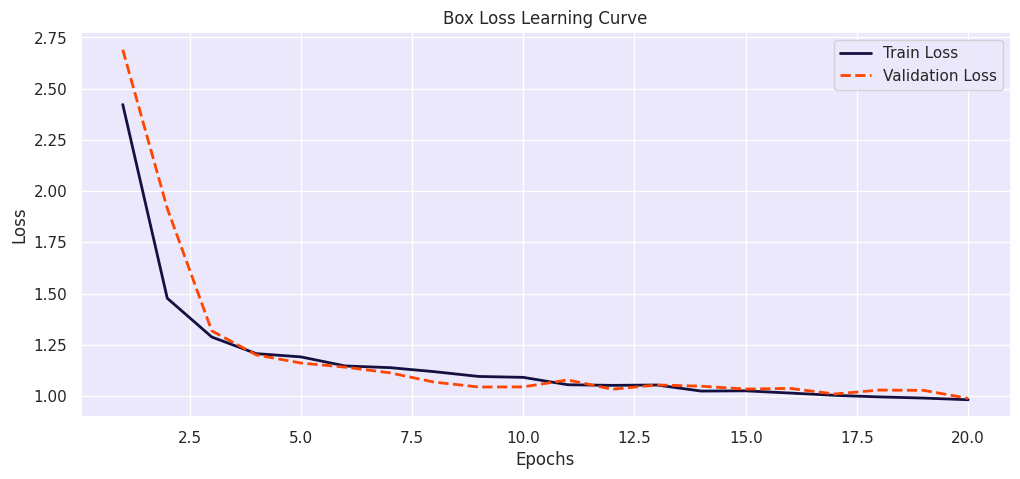

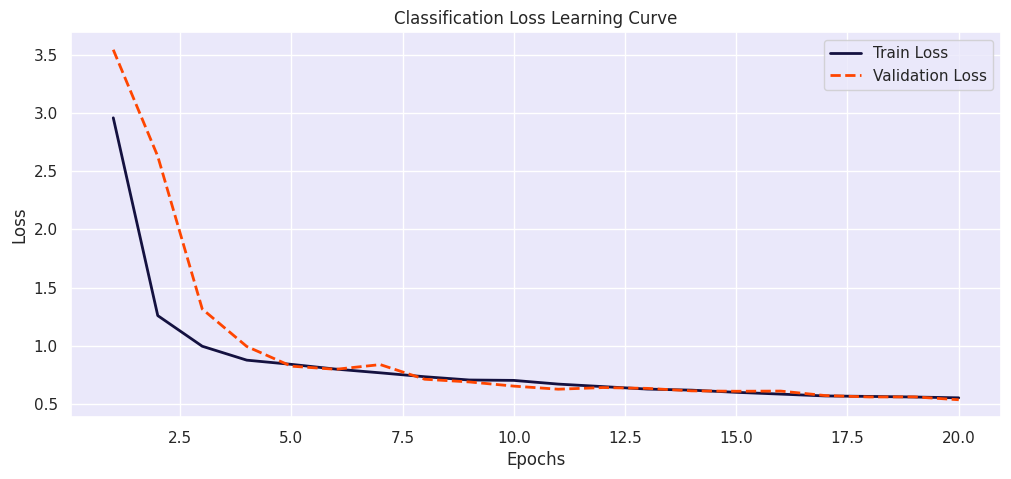

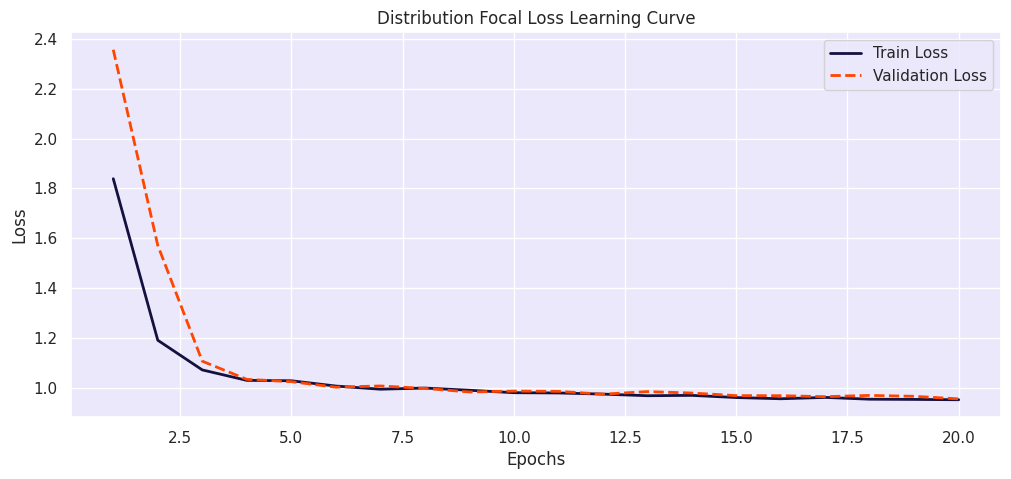

In [19]:
# Create the full file path for 'results.csv' using the directory path and file name
results_csv_path = './runs/detect/train4/results.csv'

# Load the CSV file from the constructed path into a pandas DataFrame
df = pd.read_csv(results_csv_path)

# Remove any leading whitespace from the column names
df.columns = df.columns.str.strip()

# Plot the learning curves for each loss
plot_learning_curve(df, 'train/box_loss', 'val/box_loss', 'Box Loss Learning Curve')
plot_learning_curve(df, 'train/cls_loss', 'val/cls_loss', 'Classification Loss Learning Curve')
plot_learning_curve(df, 'train/dfl_loss', 'val/dfl_loss', 'Distribution Focal Loss Learning Curve')

TypeError: Image data of dtype object cannot be converted to float

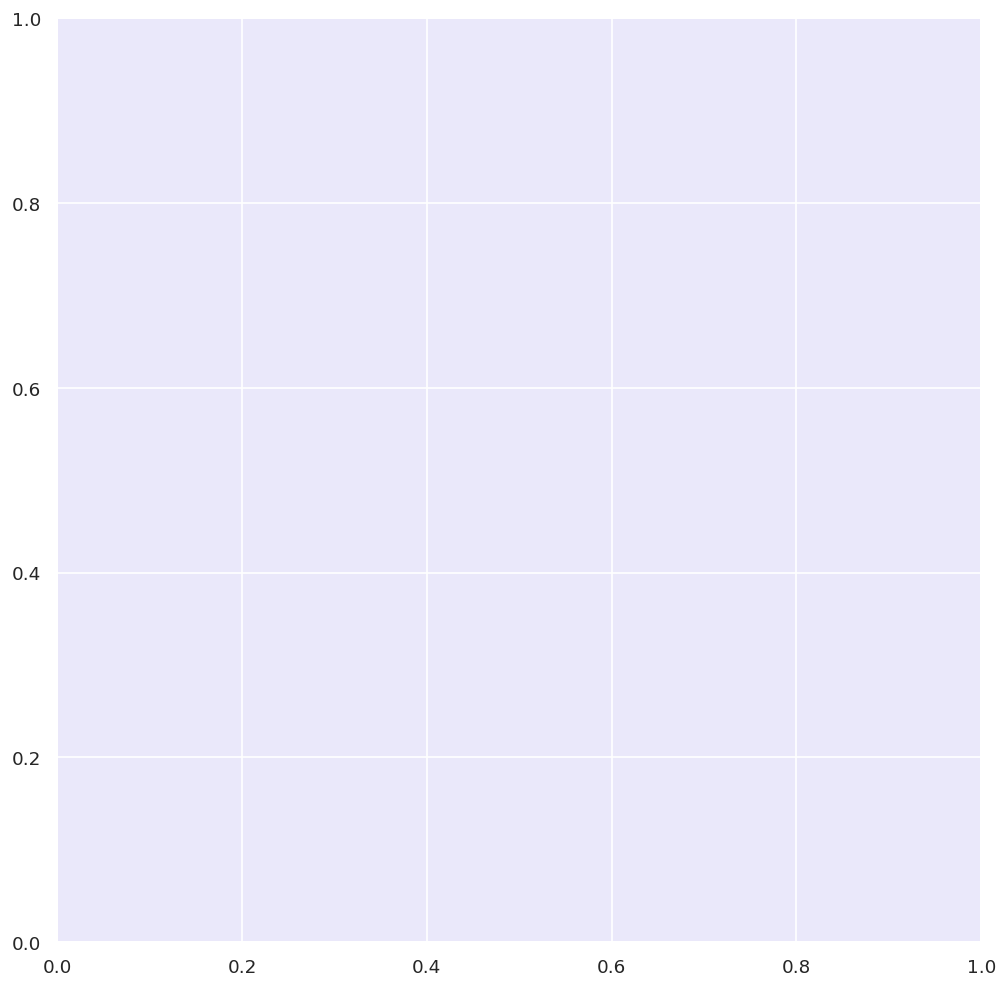

In [21]:
# Construct the path to the normalized confusion matrix image
confusion_matrix_path = os.path.join(post_training_files_path, 'confusion_matrix_normalized.png')

# Read the image using cv2
cm_img = cv2.imread(confusion_matrix_path)

# Convert the image from BGR to RGB color space for accurate color representation with matplotlib
#cm_img = cv2.cvtColor(cm_img, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 10), dpi=120)
plt.imshow(cm_img)
plt.axis('off')
plt.show()

In [23]:
# Construct the path to the best model weights file using os.path.join
best_model_path = './runs/detect/train4/weights/best.pt'

# Load the best model weights into the YOLO model
best_model = YOLO(best_model_path)

# Validate the best model using the validation set with default parameters
metrics = best_model.val(split='val')

Ultralytics YOLOv8.1.18 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid/labels.cache... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


                   all         90        937      0.912      0.916      0.969       0.71
Speed: 1.4ms preprocess, 15.2ms inference, 0.0ms loss, 7.8ms postprocess per image
Results saved to runs/detect/val


as can be seen in the above verbose

In [24]:
# Convert the dictionary to a pandas DataFrame and use the keys as the index
metrics_df = pd.DataFrame.from_dict(metrics.results_dict, orient='index', columns=['Metric Value'])

# Display the DataFrame
metrics_df.round(3)

Metric Value
metrics/precision(B)         0.912
metrics/recall(B)            0.916
metrics/mAP50(B)             0.969
metrics/mAP50-95(B)          0.710
fitness                      0.736

In [25]:
# Define the path to the validation images
valid_images_path = os.path.join(dataset_path, 'valid', 'images')

# List all jpg images in the directory
image_files = [file for file in os.listdir(valid_images_path) if file.endswith('.jpg')]

# Select 9 images at equal intervals
num_images = len(image_files)
selected_images = [image_files[i] for i in range(0, num_images, num_images // 9)]

# Initialize the subplot
fig, axes = plt.subplots(3, 3, figsize=(20, 21))
fig.suptitle('Validation Set Inferences', fontsize=24)

# Perform inference on each selected image and display it
for i, ax in enumerate(axes.flatten()):
    image_path = os.path.join(valid_images_path, selected_images[i])
    results = best_model.predict(source=image_path, imgsz=640, conf=0.5)
    annotated_image = results[0].plot(line_width=1)
    annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    ax.imshow(annotated_image_rgb)
    ax.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.


image 1/1 /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/sample_image.jpg: 384x640 6 Vehicles, 69.6ms
Speed: 2.3ms preprocess, 69.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


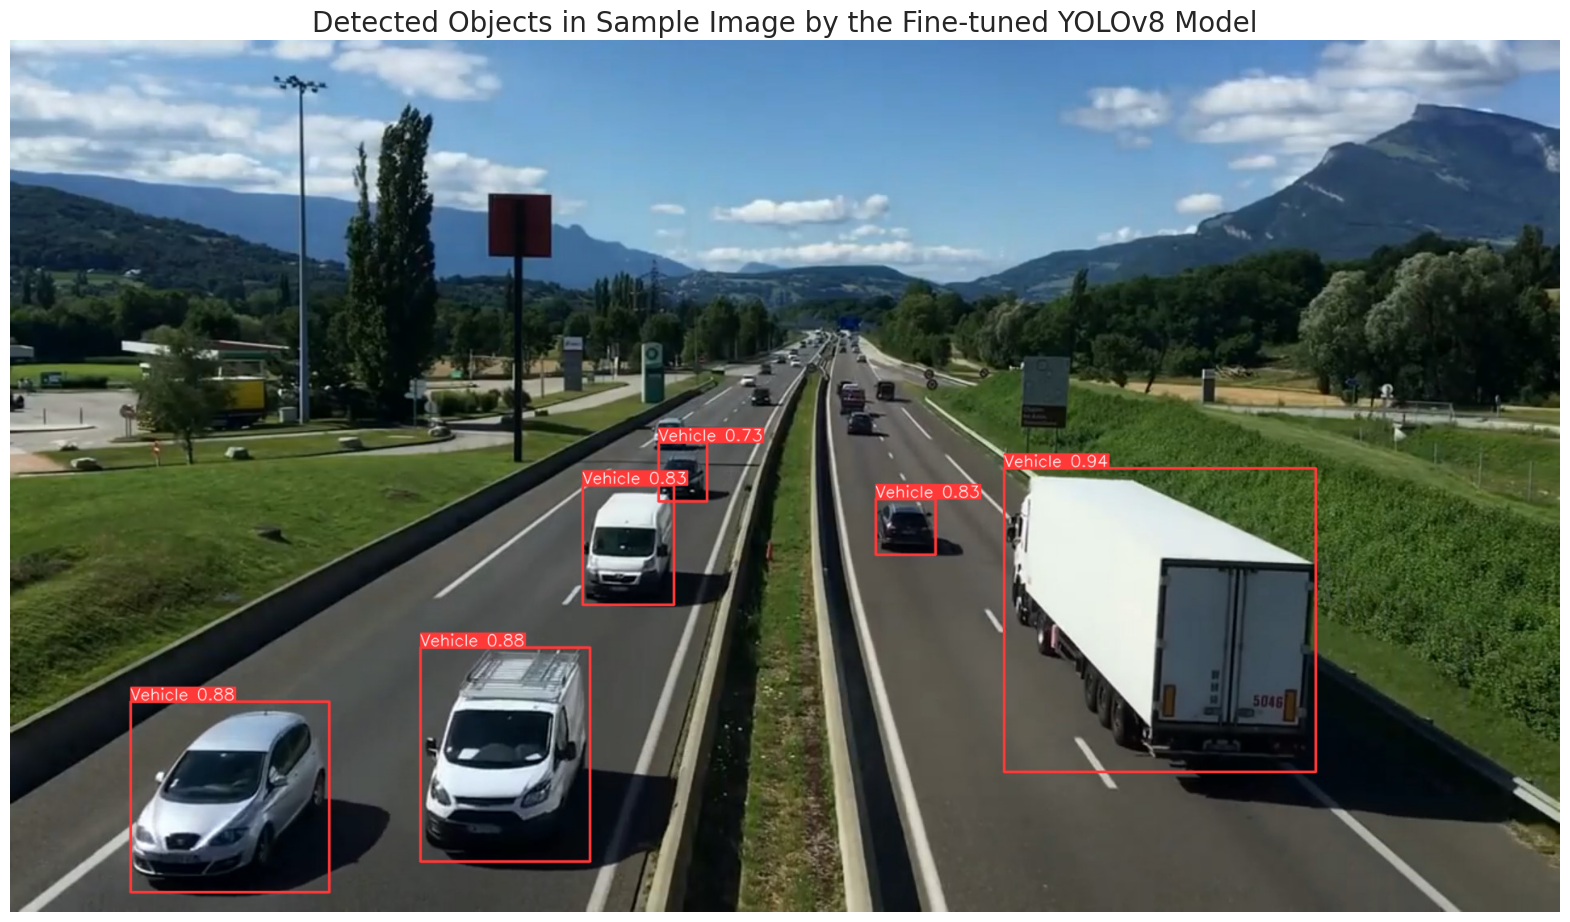

In [26]:
# Path to the image file
sample_image_path = '/kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/sample_image.jpg'

# Perform inference on the provided image using best model
results = best_model.predict(source=sample_image_path, imgsz=640, conf=0.7)

# Annotate and convert image to numpy array
sample_image = results[0].plot(line_width=2)

# Convert the color of the image from BGR to RGB for correct color representation in matplotlib
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

# Display annotated image
plt.figure(figsize=(20,15))
plt.imshow(sample_image)
plt.title('Detected Objects in Sample Image by the Fine-tuned YOLOv8 Model', fontsize=20)
plt.axis('off')
plt.show()

In [27]:
# Define the path to the sample video in the dataset
dataset_video_path = '/kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/sample_video.mp4'

# Define the destination path in the working directory
video_path = '/kaggle/working/sample_video.mp4'

# Copy the video file from its original location in the dataset to the current working directory in Kaggle for further processing
shutil.copyfile(dataset_video_path, video_path)

# Initiate vehicle detection on the sample video using the best performing model and save the output
best_model.predict(source=video_path, save=True)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/601) /kaggle/working/sample_video.mp4: 384x640 4 Vehicles, 9.0ms
video 1/1 (2/601) /kaggle/working/sample_video.mp4: 384x640 5 Vehicles, 10.8ms
video 1/1 (3/601) /kaggle/working/sample_video.mp4: 384x640 5 Vehicles, 10.9ms
video 1/1 (4/601) /kaggle/working/sample_video.mp4: 384x640 3 Vehicles, 11.0ms
video 1/1 (5/601) /kaggle/working/sample_video.mp4: 384x640 4 Vehicles, 8.8ms
video 1/1 (6/601) /kaggle/working/sample_video.mp4: 384x640 3 V

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Vehicle'}
 obb: None
 orig_img: array([[[252, 245, 242],
         [252, 245, 242],
         [252, 245, 242],
         ...,
         [210, 184, 166],
         [210, 184, 166],
         [210, 184, 166]],
 
        [[252, 245, 242],
         [252, 245, 242],
         [252, 245, 242],
         ...,
         [210, 184, 166],
         [210, 184, 166],
         [210, 184, 166]],
 
        [[254, 246, 241],
         [254, 246, 241],
         [254, 246, 241],
         ...,
         [210, 184, 166],
         [210, 184, 166],
         [210, 184, 166]],
 
        ...,
 
        [[ 94, 104, 103],
         [ 96, 106, 105],
         [101, 111, 110],
         ...,
         [ 94, 106, 111],
         [ 95, 107, 112],
         [ 97, 109, 114]],
 
        [[ 98, 108, 107],
         [103, 113, 112],
         [100, 110, 109],
         ...,
         [ 95, 10

In [28]:
# Convert the .avi video generated by the YOLOv8 prediction to .mp4 format for compatibility with notebook display
!ffmpeg -y -loglevel panic -i /kaggle/working/runs/detect/predict/sample_video.avi processed_sample_video.mp4

# Embed and display the processed sample video within the notebook
Video("processed_sample_video.mp4", embed=True, width=960)

In [29]:
# Define the threshold for considering traffic as heavy
heavy_traffic_threshold = 10

# Define the vertices for the quadrilaterals
vertices1 = np.array([(465, 350), (609, 350), (510, 630), (2, 630)], dtype=np.int32)
vertices2 = np.array([(678, 350), (815, 350), (1203, 630), (743, 630)], dtype=np.int32)

# Define the vertical range for the slice and lane threshold
x1, x2 = 325, 635
lane_threshold = 609

# Define the positions for the text annotations on the image
text_position_left_lane = (10, 50)
text_position_right_lane = (820, 50)
intensity_position_left_lane = (10, 100)
intensity_position_right_lane = (820, 100)

# Define font, scale, and colors for the annotations
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_color = (255, 255, 255)    # White color for text
background_color = (0, 0, 255)  # Red background for text

# Open the video
cap = cv2.VideoCapture('sample_video.mp4')

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('traffic_density_analysis.avi', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

# Read until video is completed
while cap.isOpened():
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret:
        # Create a copy of the original frame to modify
        detection_frame = frame.copy()

        # Black out the regions outside the specified vertical range
        detection_frame[:x1, :] = 0  # Black out from top to x1
        detection_frame[x2:, :] = 0  # Black out from x2 to the bottom of the frame

        # Perform inference on the modified frame
        results = best_model.predict(detection_frame, imgsz=640, conf=0.4)
        processed_frame = results[0].plot(line_width=1)

        # Restore the original top and bottom parts of the frame
        processed_frame[:x1, :] = frame[:x1, :].copy()
        processed_frame[x2:, :] = frame[x2:, :].copy()

        # Draw the quadrilaterals on the processed frame
        cv2.polylines(processed_frame, [vertices1], isClosed=True, color=(0, 255, 0), thickness=2)
        cv2.polylines(processed_frame, [vertices2], isClosed=True, color=(255, 0, 0), thickness=2)

        # Retrieve the bounding boxes from the results
        bounding_boxes = results[0].boxes

        # Initialize counters for vehicles in each lane
        vehicles_in_left_lane = 0
        vehicles_in_right_lane = 0

        # Loop through each bounding box to count vehicles in each lane
        for box in bounding_boxes.xyxy:
            # Check if the vehicle is in the left lane based on the x-coordinate of the bounding box
            if box[0] < lane_threshold:
                vehicles_in_left_lane += 1
            else:
                vehicles_in_right_lane += 1

        # Determine the traffic intensity for the left lane
        traffic_intensity_left = "Heavy" if vehicles_in_left_lane > heavy_traffic_threshold else "Smooth"
        # Determine the traffic intensity for the right lane
        traffic_intensity_right = "Heavy" if vehicles_in_right_lane > heavy_traffic_threshold else "Smooth"


        # Add a background rectangle for the left lane vehicle count
        cv2.rectangle(processed_frame, (text_position_left_lane[0]-10, text_position_left_lane[1] - 25),
                      (text_position_left_lane[0] + 460, text_position_left_lane[1] + 10), background_color, -1)

        # Add the vehicle count text on top of the rectangle for the left lane
        cv2.putText(processed_frame, f'Vehicles in Left Lane: {vehicles_in_left_lane}', text_position_left_lane,
                    font, font_scale, font_color, 2, cv2.LINE_AA)

        # Add a background rectangle for the left lane traffic intensity
        cv2.rectangle(processed_frame, (intensity_position_left_lane[0]-10, intensity_position_left_lane[1] - 25),
                      (intensity_position_left_lane[0] + 460, intensity_position_left_lane[1] + 10), background_color, -1)

        # Add the traffic intensity text on top of the rectangle for the left lane
        cv2.putText(processed_frame, f'Traffic Intensity: {traffic_intensity_left}', intensity_position_left_lane,
                    font, font_scale, font_color, 2, cv2.LINE_AA)

        # Add a background rectangle for the right lane vehicle count
        cv2.rectangle(processed_frame, (text_position_right_lane[0]-10, text_position_right_lane[1] - 25),
                      (text_position_right_lane[0] + 460, text_position_right_lane[1] + 10), background_color, -1)

        # Add the vehicle count text on top of the rectangle for the right lane
        cv2.putText(processed_frame, f'Vehicles in Right Lane: {vehicles_in_right_lane}', text_position_right_lane,
                    font, font_scale, font_color, 2, cv2.LINE_AA)

        # Add a background rectangle for the right lane traffic intensity
        cv2.rectangle(processed_frame, (intensity_position_right_lane[0]-10, intensity_position_right_lane[1] - 25),
                      (intensity_position_right_lane[0] + 460, intensity_position_right_lane[1] + 10), background_color, -1)

        # Add the traffic intensity text on top of the rectangle for the right lane
        cv2.putText(processed_frame, f'Traffic Intensity: {traffic_intensity_right}', intensity_position_right_lane,
                    font, font_scale, font_color, 2, cv2.LINE_AA)

        # Write the processed frame to the output video
        out.write(processed_frame)

        # Uncomment the following 3 lines if running this code on a local machine to view the real-time processing results
        # cv2.imshow('Real-time Analysis', processed_frame)
        # if cv2.waitKey(1) & 0xFF == ord('q'):  # Press Q on keyboard to exit the loop
        #     break
    else:
        break

# Release the video capture and video write objects
cap.release()
out.release()

# Close all the frames
# cv2.destroyAllWindows()

In [30]:
# Convert the .avi video generated by our traffic density estimation app to .mp4 format for compatibility with notebook display
!ffmpeg -y -loglevel panic -i /kaggle/working/traffic_density_analysis.avi traffic_density_analysis.mp4

# Embed and display the processed sample video within the notebook
Video("traffic_density_analysis.mp4", embed=True, width=960)

In [31]:
# Export the model
best_model.export(format='onnx')

Ultralytics YOLOv8.1.18 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/detect/train4/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 79.2 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 8.2s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.15.0 opset 17...
ONNX: export success ✅ 9.0s, saved as 'runs/detect/train4/weights/best.onnx' (11.7 MB)

Export complete (10.6s)
Results saved to /content/runs/detect/train4/weights
Predict:         yolo predict task=detect model=runs/detect/train4/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train4/weights/best.onnx imgsz=640 data=/kaggle/input/top-view-vehicle-det

'runs/detect/train4/weights/best.onnx'